In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F # layer나 LS 같은 함수들이 포함된 모듈

In [6]:
class Net(nn.Module):                   # nn.Module을 상속하여 새로운 신경망 클래스를 정의

    def __init__(self):                 # 클래스 생성자
        super(Net, self).__init__()     # 네트워크 layer를 정의

        self.conv1 = nn.Conv2d(1,6,3)   # 입력 1, 출력 6, 필터(3x3)
        self.conv2 = nn.Conv2d(6,16,3)  # 입력 6(이전 레이어의 출력 채널과 동일), 출력 16, 필터(3x3)
        self.fc1 = nn.Linear(16*6*6, 120)  # 입력 16*6*6 (컨볼루션과 풀링 후 펼쳐진 결과)
        self.fc2 = nn.Linear(120, 84)   # 입력 120, 출력 84
        self.fc3 = nn.Linear(84, 10)    # 입력 84, 출력 10 (예: 10개의 클래스 분류)

    def forward(self, x):               # *순전파*를 정의
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))  # self.conv1 연산, ReLU 활성화 함수 적용, (2x2) 맥스 풀링 수행
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # self.conv2 연산, ReLU와 (2x2) 맥스 풀링 수행, 위에랑 똑같으나 커널 크기를 *정수*로 표현
        x = x.view(-1, self.num_flat_features(x))  # 입력 데이터를 펼침
        x = F.relu(self.fc1(x))         # fc1 통과, relu 함수 적용
        x = F.relu(self.fc2(x))         # fc2 통과, relu 함수 적용
        x = self.fc3(x)                 # fc3 통과, 활성화 함수가 없는 출력 
        return x
    
    def num_flat_features(self, x):     # 입력 x의 크기를 계산하여 fc층에 전달할 수 있도록 펼친 특성의 수를 계산
        size = x.size()[1:]             # 배치 크기를 제외한 나머지 크기 가져옴
        num_features = 1                # 만약 입력 x의 크기가 (batch_size, 16, 6, 6) 이라면
        for s in size:                  # size = (16, 6, 6)
            num_features *= s           # num_features = 16 * 6 * 6 = 576

        return num_features
    
net = Net()                             # Net 클래스를 인스턴스화하여 모델 객체를 생성성
print(net)                              # 정의된 네트워크 구조를 출력 

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

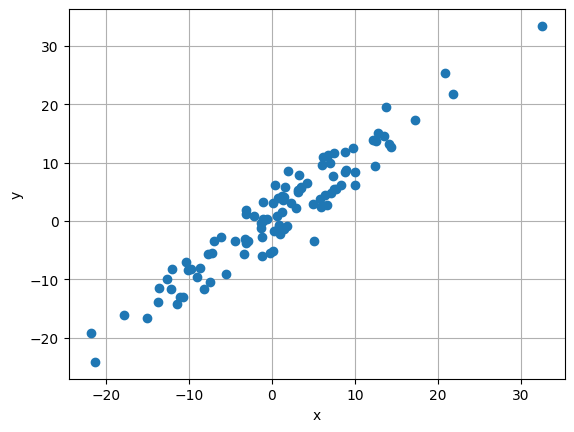

In [8]:
X = torch.randn(100,1)*10               # 정규분포에서 100개 (x 10)의 샘플 생성
y = X + 3 * torch.randn(100,1)          # y는 X랑 대략 선형 관계를 가지지만, 노이즈로 인해 산포도가 생김 
plt.plot(X.numpy(), y.numpy(), 'o')     
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

In [9]:
# 단순히 하나의 레이어만 존재하는 신경망
class LinearRegressionModel(nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()  # nn.Module의 생성자를 호출하여 초기화함 
        self.linear = nn.Linear(1,1)            # 입력 1, 출력 1인 선형 레이어를 정의함 

    def forward(self, x):
        pred = self.linear(x)                   # 입력 x에 대해 정의된 선형 레이어를 적용 
        return pred

In [10]:
torch.manual_seed(123)                      # 랜덤 값 생성의 일관성을 보장하기 위해 시드 사용

model = LinearRegressionModel()
print(model)

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [11]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.4078]], requires_grad=True), Parameter containing:
tensor([0.0331], requires_grad=True)]


In [12]:
# 왜 파라미터 값을 list로 변환해서 나타내는가??
# -> model.parameters()는 이터레이터 형태로 반환되므로, list로 변환해야 내용을 확인 할 수 있음 

model = LinearRegressionModel()
print(model.parameters())  # 출력: <generator object Module.parameters at 0x...>
print(list(model.parameters()))  # 실제 파라미터 값이 리스트로 출력됨


<generator object Module.parameters at 0x0000020243712DD0>
[Parameter containing:
tensor([[-0.4967]], requires_grad=True), Parameter containing:
tensor([0.3771], requires_grad=True)]


In [13]:
# list 대신 1. 직접 접근하는 방법
print(model.linear.weight)  # 가중치 확인
print(model.linear.bias)    # 편향 확인

Parameter containing:
tensor([[-0.4967]], requires_grad=True)
Parameter containing:
tensor([0.3771], requires_grad=True)


In [15]:
# list 대신 2. 모델 구조와 파라미터 함께 보기 
print(model)
for name, param in model.named_parameters():
    print(name, param)


LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
linear.weight Parameter containing:
tensor([[-0.4967]], requires_grad=True)
linear.bias Parameter containing:
tensor([0.3771], requires_grad=True)


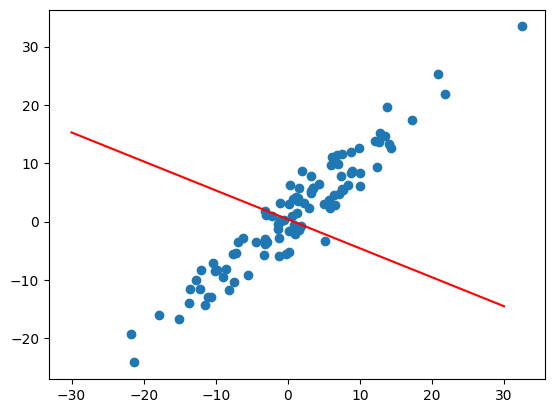

In [18]:
# 초기값 그대로를 나타낸 직선
w, b = model.parameters()
def get_params():                       # 모델의 현재 가중치와 편향 값을 반환 
    return w[0][0].item(), b[0].item()

def plot_fit(title):
    plt.title = title
    w1, b1 = get_params()
    x1 = np.array([-30, 30])
    y1 = w1 * x1 + b1
    plt.plot(x1, y1, 'r')               # 빨간색 선으로 직선 그리기 
    plt.scatter(X, y)
    plt.show()

plot_fit("Initial Model")

# 빨간 직선은 모델이 초기화된 상태에서의 가중치와 편향으로 그린 직선이라 데이터에 맞춰져 있지 않음
# 학습 과정에서 점점 데이터에 적합해짐 

In [19]:
criterion = nn.MSELoss()                    # 평균 제곱 오차의 손실 함수 정의 
optimizer = optim.SGD(model.parameters(), lr=0.001)  # 확률적 경사 하강법

In [20]:
epochs = 100                            # 학습 반복 횟수 
losses = []                             # 각 epoch에서 계산된 손실 값을 저장하기 위한 리스트트
for epoch in range(epochs):
    optimizer.zero_grad()               # 기울기를 초기화, loss.backward()를 호출할 때마다 기존 기울기를 누적하므로 초기화 시킴

    y_pred = model(X)
    loss = criterion(y_pred, y)         # 손실함수를 이용하여 예측값과 실제값 간의 오차를 계산함 
    losses.append(loss)                 # 계산된 손실 값을 losses 리스트에 추가하여 저장함
    loss.backward()                     # 역전파를 수행하여 손실에 대한 각 파라미터의 기울기를 계산함

    optimizer.step()                    # 옵티마이저를 사용하여 계산된 기울기를 기반으로 모델의 파라미터를 업데이트함함

    if epoch % 10 == 0:                 # 10번의 반복마다 학습 상태를 출력함 
        print("Epoch: {:3d}\tloss: {:.4f}".format(epoch+1, loss))

Epoch:   1	loss: 202.5648
Epoch:  11	loss: 12.7564
Epoch:  21	loss: 8.4058
Epoch:  31	loss: 8.3060
Epoch:  41	loss: 8.3037
Epoch:  51	loss: 8.3035
Epoch:  61	loss: 8.3035
Epoch:  71	loss: 8.3034
Epoch:  81	loss: 8.3033
Epoch:  91	loss: 8.3033


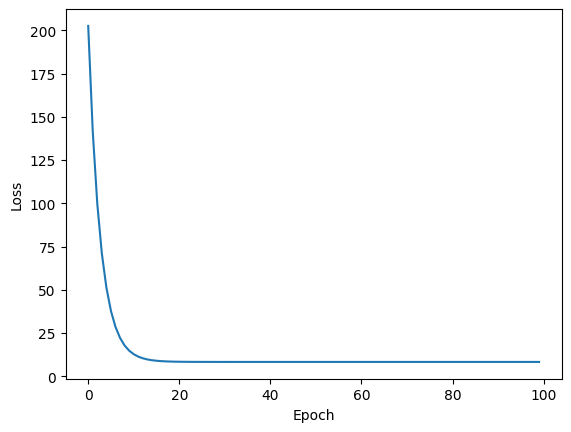

[tensor(202.5648, grad_fn=<MseLossBackward0>), tensor(141.4742, grad_fn=<MseLossBackward0>), tensor(99.5952, grad_fn=<MseLossBackward0>), tensor(70.8862, grad_fn=<MseLossBackward0>), tensor(51.2055, grad_fn=<MseLossBackward0>), tensor(37.7139, grad_fn=<MseLossBackward0>), tensor(28.4652, grad_fn=<MseLossBackward0>), tensor(22.1249, grad_fn=<MseLossBackward0>), tensor(17.7785, grad_fn=<MseLossBackward0>), tensor(14.7989, grad_fn=<MseLossBackward0>), tensor(12.7564, grad_fn=<MseLossBackward0>), tensor(11.3562, grad_fn=<MseLossBackward0>), tensor(10.3963, grad_fn=<MseLossBackward0>), tensor(9.7382, grad_fn=<MseLossBackward0>), tensor(9.2871, grad_fn=<MseLossBackward0>), tensor(8.9779, grad_fn=<MseLossBackward0>), tensor(8.7659, grad_fn=<MseLossBackward0>), tensor(8.6206, grad_fn=<MseLossBackward0>), tensor(8.5210, grad_fn=<MseLossBackward0>), tensor(8.4527, grad_fn=<MseLossBackward0>), tensor(8.4058, grad_fn=<MseLossBackward0>), tensor(8.3737, grad_fn=<MseLossBackward0>), tensor(8.3517, g

In [ ]:
plt.plot(range(epochs), torch.Tensor(losses)) # 에러 났는데 댓글보고 고침 
# plt.plot(range(epochs), losses) 로 하면 losses 리스트에 저장된 값이 torch.Tensor 객체이기 때문에
# 직접적으로 plt.plot()에 전달하면 Matplotlib에서 처리하지 못하고 오류를 발생시킴 

# print(losses)
# print(torch.Tensor(losses))

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

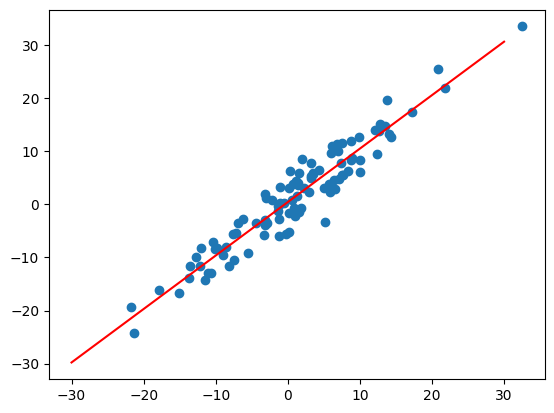

In [22]:
plot_fit("Trained Model")

In [2]:
import torch
from torch import nn

# 시드 설정 없음
model1 = nn.Linear(1, 1)
model2 = nn.Linear(1, 1)

# 두 모델의 가중치 비교
print("Model 1 weights:", model1.weight)
print("Model 2 weights:", model2.weight)


Model 1 weights: Parameter containing:
tensor([[0.7362]], requires_grad=True)
Model 2 weights: Parameter containing:
tensor([[0.3429]], requires_grad=True)


In [3]:
# 시드 설정
torch.manual_seed(123)
model1 = nn.Linear(1, 1)

torch.manual_seed(123)
model2 = nn.Linear(1, 1)

# 두 모델의 가중치 비교
print("Model 1 weights:", model1.weight)
print("Model 2 weights:", model2.weight)


Model 1 weights: Parameter containing:
tensor([[-0.4078]], requires_grad=True)
Model 2 weights: Parameter containing:
tensor([[-0.4078]], requires_grad=True)
